In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from matplotlib import pyplot
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output
from PIL import Image           # The Python Image Library (PIL)
import collections
import keras

# test harness for evaluating models on the cifar10 dataset
import sys
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, losses
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import img_to_array, load_img

In [ ]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
numClasses = len(classes)

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':   
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        #print(len(X[0]))
        Y = datadict['labels']
        X = X.reshape(10000, 32, 32, 3)
        #X = np.array(X)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):    
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte      

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
#def get_CIFAR10_data(num_training=100, num_validation=10, num_test=10):
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/drive/My Drive/ML/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    # X_train[num_training: num_training + num_validation]
    X_val = X_train[mask]   
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test

In [ ]:
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()

# One hot encoding
y_train = keras.utils.to_categorical(y_train, numClasses)
y_test = keras.utils.to_categorical(y_test, numClasses)

# NOTE: Passing the y_train for y_val
y_val = keras.utils.to_categorical(y_train, numClasses)

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (100, 32, 32, 3)
Train labels shape:  (100, 10)
Validation data shape:  (10, 32, 32, 3)
Validation labels shape:  (100, 10, 10)
Test data shape:  (10, 32, 32, 3)
Test labels shape:  (10, 10)


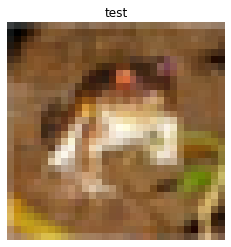

In [ ]:

# The images are index 0 of the dictionary
# They are stored as a 3072 element vector so we need to reshape this into a tensor.
# The first dimension is the red/green/blue channel, the second is the pixel row, the third is the pixel column
im = x_train[0].reshape(3,32,32)

# PIL and matplotlib want the red/green/blue channels last in the matrix. So we just need to rearrange 
# the tensor to put that dimension last.
im = np.transpose(im, axes=[1, 2, 0])  # Put the 0-th dimension at the end

# Image are supposed to be unsigned 8-bit integers. If we keep the raw images, then
# this line is not needed. However, if we normalize or whiten the image, then the values become
# floats. So we need to convert them back to uint8s.
im = (im * 255).astype(np.uint8)
im = np.uint8(im)  

im=Image.fromarray(im)

plt.imshow(im);
plt.title("test");
plt.axis('off');

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
x_train.shape

(49000, 32, 32, 3)

In [ ]:
def train_cars_model():
    
    # Data augmentation
    train_datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.1, width_shift_range=0.1)
    train_iter = train_datagen.flow(x_train, y_train, batch_size=64)

    # Instantiate the callback
    # callbacks = myCallback()

    ### START CODE HERE

    # Define the model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    

    # Compile the model
    # SGD
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(learning_rate=0.001),
                  metrics=['accuracy']) 
    
    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    
    # fits the model on batches with real-time data augmentation:
    history= model.fit(
                train_iter,
                steps_per_epoch= int(x_train.shape[0] / 64),
                epochs=100,
                validation_data=(x_test, y_test),
                shuffle=True,
                verbose=2, 
                # callbacks=[callbacks],
                initial_epoch= 0
            )
   

    return history

1/1 - 4s - loss: 4.0597 - accuracy: 0.1094 - val_loss: 6.4661 - val_accuracy: 0.0000e+00 - 4s/epoch - 4s/step
[0.109375]


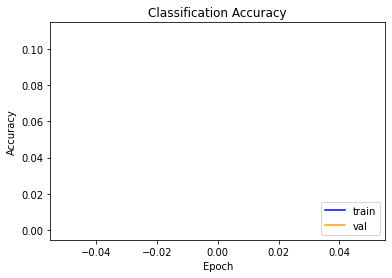

In [ ]:
hist = train_cars_model()
pyplot.title('Classification Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.plot(hist.history['accuracy'], color='blue', label='train')
pyplot.plot(hist.history['val_accuracy'], color='orange', label='val')
pyplot.legend(loc='lower right')
print (hist.history['accuracy'])

# save model
hist.model.save("/content/drive/My Drive/ML/saved_model.h5");

In [ ]:
# ## load tensorflow model
new_model = tf.keras.models.load_model("/content/drive/My Drive/ML/saved_model.h5")
print(new_model.summary())
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('> %.3f' % (acc * 100.0))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

1/1 - 1s - loss: 6.4661 - accuracy: 0.0000e+00 - 702ms/epoch - 702ms/step
> 0.000


In [ ]:
path = '/content/drive/My Drive/ML/carcool.png'
img = load_img(path, target_size=(32, 32))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = hist.model.predict(images, batch_size=10)
print(classes)
if max(classes[0]) == classes[0][1]:
  print(path + " is a car")
else:
  print(path + " is NOT a car")

1/1 [==============================] - 0s 193ms/step
[[3.5888009e-04 3.5732093e-03 2.6324212e-03 6.6485238e-04 1.6771468e-04
  4.2071808e-04 2.8080183e-09 1.5419755e-03 2.1147267e-04 9.9042881e-01]]
/content/drive/My Drive/ML/carcool.png is NOT a car
